In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from scipy.interpolate import interp1d
from scipy.optimize import minimize

## Part III : Economic model for dike cost and economic loss

Here we are given various data points for cost functions so that we can choose $h_d$ to minimize the total cost of the dike over its lifetime $T$.

First we consider the construction and maintenance cost of the dike $C_t$ given by :
$$ C_t = C_i(h_d) + T C_m(h_d) $$
Where $C_i(h_d)$ is the investment cost given in a table, $C_m$ the maintenance cost equal to $1\%$ of $C_i$

Then we have the annual cost of damage $C_d$, given by :
$$ C_d = C_s(S) + C_g(S) $$
Both values for $C_s$ and $C_g$ are tabulated in relation to the overflow height. We can see that $C_d$ is a random variable, as it is a function of the random variable $S$.

We want to minimize the mean annual cost of the plant over its lifetime $T$:
$$ C_{c,mean} = \frac{ C_t + \sum_i C_{d,i} }{T} $$

### 1 : Interpolate our tabulated values to a linear by part cost function

In [10]:
# Tabulated values for Ci
h_data = [0, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Ci_data = [0, 100, 225, 1034, 4750, 11023, 16971, 21692, 26509, 31408, 36377, 41409, 46498]

# Interpolated Ci(h_d) function
Ci_func = interp1d(h_data, Ci_data)

In [11]:
# Tabulated values for Cs and Cg
S_data = [-100, -0.1, 0, 0.5, 1, 1.5, 2, 100]
Cs_data = [0, 0, 0, 150, 1500, 2000, 2000, 2000]
Cg_data = [0, 0, 0.1, 0.5, 1, 1, 1, 1]

# Interpolated Cs(S) and Cg(S) functions
Cs_func = interp1d(S_data, Cs_data)
Cg_func = interp1d(S_data, Cg_data)

### 2 : Generate our random variables to get a pdf for S

In [12]:
# Constants
L = 5000    # Length of section (m)
B = 300     # Watercourse width (m)
Zb = 55.5  # Shoreline elevation (m NGF)

# Simulation parameters 
vec_size = 100000                # Points to generate

def simulation(vec_size):
    """
    Generates a vector of observations of S s.t h_d=0
    """
    mode_Q, scale_Q = 1013, 558 # Q law (Gumbel)
    exp_K, std_K = 30, 7.5      # Ks law (Gaussian)
    exp_Zv, hr_Zv = 50, 1       # Zv law (Triangular)
    exp_Zm, hr_Zm = 55, 1       # Zm law (Triangular)

    # Generate random variables vectors of size vec_size
    Q_vec = stat.gumbel_r.rvs(loc=mode_Q, scale=scale_Q, size=vec_size)
    Ks_vec = stat.norm.rvs(loc=exp_K, scale=std_K, size=vec_size)
    Zv_vec = stat.triang.rvs(c=1/2, loc=exp_Zv-hr_Zv, scale=2*hr_Zv, size=vec_size)
    Zm_vec = stat.triang.rvs(c=1/2, loc=exp_Zm-hr_Zm, scale=2*hr_Zm, size=vec_size)

    to_remove_ind = [] # List of indexes that violate positivity criteria
    for i in range(len(Q_vec)):
        if Q_vec[i]<=0:
            to_remove_ind.append(i)
        if Ks_vec[i]<=1:
            to_remove_ind.append(i)
    to_remove_ind = np.array(to_remove_ind)

    # Removing these indices from the dataset
    Q_vec = np.delete(Q_vec, to_remove_ind)
    Ks_vec = np.delete(Ks_vec, to_remove_ind)
    Zv_vec = np.delete(Zv_vec, to_remove_ind)
    Zm_vec = np.delete(Zm_vec, to_remove_ind)

    H_vec = (Q_vec/(Ks_vec*B*np.sqrt((Zm_vec-Zv_vec)/L)))**(3/5)
    S = Zv_vec + H_vec - Zb
    return S

### 3 : Minimizing the expected annual cost for the dike

Here, we want to minimize the expected mean annual cost for the dike :
$$ C = \mathbb{E}(C_{c,mean}) = \frac{C_t}{T} + \mathbb{E}(C_d(S)) $$
We suppose the damage cost to be independant of the time to have this simplified expression.

In [13]:
def total_cost(h, T, S):
    """
    h (float): Height of the dike in m
    T (int): Time interval for cost calculation in years
    S (array): Observations of the law of S s.t h=0
    Returns the expected total mean cost for the dike (in M€)
    """
    # Investment and maintenance cost
    Ci = Ci_func(h)/1000 # Conversion to M€
    Ct = (1+T/100)*Ci

    # Cost of damage distribution
    S_truth = S - h
    Cs = Cs_func(S_truth)
    Cg = Cg_func(S_truth)
    Cd = Cs + Cg*Ci

    # Expected mean cost
    Cc_m = Ct/T + np.mean(Cd)
    return Cc_m

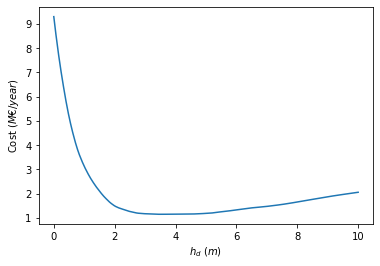

[3.66222406]


In [14]:
h_d = np.linspace(0, 10, 1000) #Test with 100 dike heights between 0 and 5 meters
T = 30 # Time for the cost calculation, here 30 years
S = simulation(vec_size)

Cc_mean = np.array([total_cost(h, T, S) for h in h_d])

plt.figure()
plt.plot(h_d, Cc_mean)
plt.xlabel(r"$h_d$ ($m$)")
plt.ylabel(r"Cost ($M€/year$)")
plt.show()

def cost_h(h):
    return total_cost(h, T, S)
res = minimize(cost_h, 1)
print(res['x'])

### 4 : Confidence interval for $h_d$

Once again, we minimize the cost function multiple times to get a confidence interval for $h_d$ and increase the robustness of our results.

In [15]:
N_iter = 1000
dike_heights = np.zeros(N_iter)

for i in range(N_iter):
    S = simulation(vec_size)
    res = minimize(cost_h, 1)
    dike_heights[i] = res['x']

Confidence Interval for h_d at 95% confidence level :
[2.82, 4.51]
Mean value : 3.50


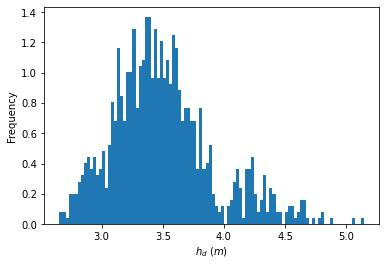

In [16]:
print("Confidence Interval for h_d at 95% confidence level :")
print("[{a:.2f}, {b:.2f}]".format(a=np.quantile(dike_heights, 0.025), b=np.quantile(dike_heights, 0.975)))
print("Mean value : {a:.2f}".format(a=np.mean(dike_heights)))

plt.figure()
plt.hist(dike_heights, bins=100, density=True)
plt.xlabel(r"$h_d$ ($m$)")
plt.ylabel("Frequency")
plt.show()